In [1]:
!pip install --user git+https://github.com/kilean20/pyTorchTemplate.git

  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-1j0jec2q
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-1j0jec2q
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6496 sha256=22e99872cc604506cc37bc56e7888b74acea3abfcdd68330f1b41405a98c8669
  Stored in directory: /tmp/pip-ephem-wheel-cache-k2ke1sr9/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [2]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [3]:
import pyTorchTemplate as ptt
device = ptt.device

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [5]:
nsample = 16
nensemble = 16
nModel = 16
nodes = [1,512,512,1]

# Targets

In [6]:
from scipy.special import airy

def func(x):
  return np.sin(np.pi*4*x)

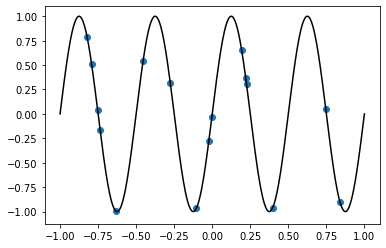

In [7]:
train_input = (np.random.rand(nsample)*2.0-1.0).reshape(-1,1).astype(np.float32)
train_output = func(train_input)

test_input = np.linspace(-1, 1, 512).reshape(-1,1).astype(np.float32)
test_output = func(test_input)

train_data_loader = torch.utils.data.DataLoader(list(zip(train_input,train_output)), batch_size=nsample, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(list(zip(test_input,test_output)), batch_size=512, shuffle=False) 

for x,y in test_data_loader:
    plt.plot(x,y,c='k')
    
for x,y in train_data_loader:
    plt.scatter(x,y)        

# GP

In [8]:
kernel = C(0.2, (1e-3, 1e3)) * RBF(1, (1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [9]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(-0.005355846345763249, -1.2522545222992676e-09)

In [10]:
gp.fit(train_input, train_output)
gp.kernel_

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


2.7**2 * RBF(length_scale=0.23)

In [11]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(0.9999999999996485, 0.9533334066265277)

In [12]:
gp_predict_mean, gp_predict_std = gp.predict(test_input, return_std=True)
gp_predict_mean = gp_predict_mean.reshape(-1)

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


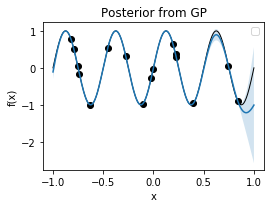

In [13]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 gp_predict_mean + 1.96*gp_predict_std, 
                 gp_predict_mean - 1.96*gp_predict_std, alpha=0.2, label='uncertainty')
plt.plot(test_input,gp_predict_mean,label='Mean')
plt.scatter(train_input,train_output,c='k',label='model on training')

# plt.legend()
plt.title('Posterior from GP')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.legend([])
plt.tight_layout()
plt.savefig('GP.png',dpi=180)

# NNensemble (ReLU)

In [14]:
def test(model,test_data_loader):
    model.eval()
    loss = 0 
    for x, y in test_data_loader:
        x = x.to(device)
        y_pred = model(x)
        loss += torch.nn.MSELoss()(y_pred, y.to(device)).item()
    return loss/len(test_data_loader)

In [15]:
model_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.ReLU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2,1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 0.45038333535194397in loss = 0.000138
1 0.4450874924659729ain loss = 0.000080
2 0.4606145918369293ain loss = 0.000094
3 0.44363391399383545in loss = 0.000107
4 0.39394059777259827in loss = 0.000033
5 0.39142727851867676in loss = 0.000030
6 0.36636078357696533in loss = 0.000002
7 0.36967772245407104in loss = 0.000031
0 0.37813976407051086in loss = 0.0003031
1 0.4638812243938446ain loss = 0.000110
2 0.45473676919937134in loss = 0.000108
3 0.4579540193080902ain loss = 0.000104
4 0.43275830149650574in loss = 0.000097
5 0.4285367429256439ain loss = 0.000068
6 0.42074134945869446in loss = 0.000110
7 0.43598082661628723in loss = 0.000094
0 0.3248033821582794ain loss = 0.0003386
1 0.3734595775604248ain loss = 0.000654
2 0.300218790769577rain loss = 0.000426
3 0.31510764360427856in loss = 0.000152
4 0.3127058744430542ain loss = 0.000183
5 0.3226501941680908ain loss = 0.000154
6 0.2696252465248108ain loss = 0.000059
7 0.35652410984039307in loss = 0.008824
0 0.4493767023086548ain loss = 0.00005

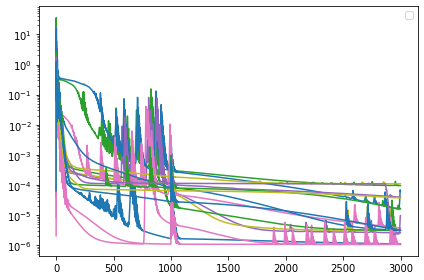

In [16]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend([])
plt.tight_layout()
plt.savefig('NNensemble_ReLU_hist.png',dpi=180)

In [17]:
model_test_outputs = np.array(model_test_outputs)
model_test_outputs_mean = np.mean(model_test_outputs,axis=0).reshape(-1,1)
model_test_outputs_std  = np.std(model_test_outputs,axis=0).reshape(-1,1)

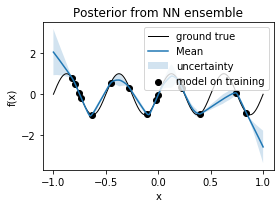

In [18]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2, label='uncertainty')
plt.plot(test_input,model_test_outputs_mean,label='Mean')
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.legend()
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('NNensemble_ReLU.png',dpi=180)

# NNensemble (CELU)

In [19]:
odel_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.CELU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2, 1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 0.5192227363586426ain loss = 0.003721
1 0.40930140018463135in loss = 0.000531
2 0.5746343731880188ain loss = 0.002090
3 0.46686995029449463in loss = 0.000350
4 0.4796057343482971ain loss = 0.000335
5 0.4668954014778137ain loss = 0.000244
6 0.3913652300834656ain loss = 0.000172
7 0.3295084536075592ain loss = 0.000154
0 0.6271132826805115ain loss = 0.0919794
1 0.473908394575119rain loss = 0.001462
2 0.3606301248073578ain loss = 0.000305
3 0.3385378420352936ain loss = 0.000117
4 0.41790786385536194in loss = 0.000102
5 0.3684285283088684ain loss = 0.000048
6 0.270372211933136rain loss = 0.028978
7 0.19693347811698914in loss = 0.015368
0 0.47991159558296204in loss = 0.0396241
1 0.4908749461174011ain loss = 0.000434
2 0.6462631821632385ain loss = 0.000269
3 0.4297649562358856ain loss = 0.000110
4 0.4645470082759857ain loss = 0.000188
5 0.3551838994026184ain loss = 0.000167
6 0.2818371057510376ain loss = 0.000128
7 0.2698902189731598ain loss = 0.000146
0 0.4163806438446045ain loss = 0.00550

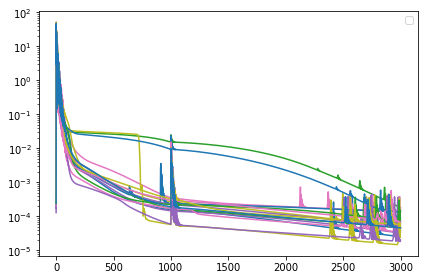

In [20]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend([])
plt.tight_layout()
plt.savefig('NNensemble_CELU_hist.png',dpi=180)

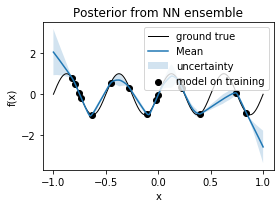

In [21]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2, label='uncertainty')
plt.plot(test_input,model_test_outputs_mean,label='Mean')
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.legend()
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('NNensemble_CELU.png',dpi=180)